# Capstone Project - The Battle of the Neighborhoods (Week 2)


## Introduction <a name="introduction"></a>

In this project, I will try to find an optimal location to rent an apartment in Toronto. I will try to apply the data science techniques to discover the utmost neighborhoods in the city of Toronto based on the following criterias:

* Number of groccery stores.
* Number of parks	
* Number of coffee shops	
* Number of resturants	
* Number of transit stops	
* Crime rates	
* Average price of rentals

## Data <a name="data"></a>

I decided to use the following data sources for the defined criterias:

* `https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M`: which corresponds to the neighborhoods of Toronto

* `http://cocl.us/Geospatial_data`: This data source contains the coordinates of each postal code. Therefore, its corresponding neighborhoods.
* **Foursquare API**: to explore each neighborhood.
* `https://www.kaggle.com/brahmdata/major-crime-indicators201419-toronto-police`: The location of any crime that happened in Toronto from 2014 till 2019.
* `https://www.kaggle.com/rajacsp/toronto-apartment-price`: The address and the rent of each available apartment in Toronto.

* `https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/c1264e07-3c27-490f-9362-42c1c8f03708`: The location of transit stops in Toronto


In [1136]:
import pandas as pd
import numpy as np
# !conda install -c conda-forge folium=0.5.0 --yes
# import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

### Toronto Neighborhoods

In this step, I will retrieve the postal codes of the city of toronto and then create the dataframe of neighborhoods based on that.

I will also disregard the postal codes that doesn't have any assigned neighborhoods or borough in the wikipedia page.

In [983]:
import requests
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
req = requests.get(url)
soup = BeautifulSoup(req.content)

In [1105]:
table_contents=[]
table=soup.find('table')
i=0
for row in table.findAll('td'):
    cell = {}

    if row.span.text=='Not assigned':
        i+=1
        pass
    else:
        
        tmp=(((((row.span.text).split('(')[1]).strip(')')).split(' /')))
        
        for n in tmp:
            cell['PostalCode'] = row.p.text[:3]
            cell['Borough'] = (row.span.text).split('(')[0]
            cell['Neighborhood']=n.replace(')',' ').strip(' ')
            
#         cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df['Neighborhood']=df['Neighborhood'].replace({'Enclave of M5E':'The Esplanade'})

print(i)

77


In [987]:
long_lat=pd.read_csv("Geospatial_Coordinates.csv")
long_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [1065]:
long_lat.rename(columns={'Postal Code':'PostalCode'},inplace=True)
toronto_data = pd.merge(df,long_lat,on='PostalCode')
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Explore the neighborhoods in Toronto

In [1066]:
{
    "tags": [
        "remove_cell",
    ]
}

CLIENT_ID = 'XLWII1PFOI2UFZ0YAJXIYNIC4FRZN3HZSJX2KW31DDCBCS2S' # your Foursquare ID
CLIENT_SECRET = 'QP2TDLEOJTXIYLW2SFNPQRMK0S2J4MXAIW2DRBYDVR2VKBCA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API


In [1067]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1068]:
toronto_venues=getNearbyVenues(names=toronto_data['Neighborhood'],latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [1069]:
# one hot encoding

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop('Neighborhood',axis=1,inplace=True)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns=[toronto_onehot.columns[-1]]
grocery_stores=0
for category in list(toronto_onehot.columns[:-1]):
    if ("Grocery Store" in category):
        grocery_stores+=1
        fixed_columns.append(category)
        
pharmacy=grocery_stores     
for category in list(toronto_onehot.columns[:-1]):
    if ("Pharmacy" in category) :
        pharmacy+=1
        fixed_columns.append(category)
        
parks=pharmacy
for category in list(toronto_onehot.columns[:-1]):
    if ("Park" in category) :
        parks+=1
        fixed_columns.append(category)

coffee_shops=parks
for category in list(toronto_onehot.columns[:-1]):
    if ("Coffee Shop" in category) or ("Café" in category) :
        coffee_shops+=1
        fixed_columns.append(category)   

restaurants=coffee_shops
for category in list(toronto_onehot.columns[:-1]):
    if ("Restaurant" in category) :
        restaurants+=1
        fixed_columns.append(category)



toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot=toronto_onehot.groupby('Neighborhood').sum()



In [1070]:
toronto_onehot['Grocery Stores']=toronto_onehot.iloc[:,0:grocery_stores].sum(axis=1)

toronto_onehot['Pharmacies']=toronto_onehot.iloc[:,grocery_stores:pharmacy].sum(axis=1)

toronto_onehot['Parks']=toronto_onehot.iloc[:,pharmacy:parks].sum(axis=1)

toronto_onehot['Coffee Shops']=toronto_onehot.iloc[:,parks:coffee_shops].sum(axis=1)

toronto_onehot['Resturants']=toronto_onehot.iloc[:,coffee_shops:restaurants].sum(axis=1)

new_columns=['Neighborhood','Grocery Stores','Pharmacies','Parks','Coffee Shops','Resturants']
toronto_onehot.reset_index(inplace=True)
toronto_onehot=toronto_onehot[new_columns]

toronto_onehot.head()



,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants
0,Agincourt,0,0,0,0,1
1,Albion Gardens,2,1,0,0,1
2,Bayview Village,0,0,0,1,2
3,Berczy Park,0,2,1,5,13
4,Cabbagetown,1,1,1,6,11


In [1072]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants
0,Agincourt,0,0,0,0,1
1,Albion Gardens,2,1,0,0,1
2,Bayview Village,0,0,0,1,2
3,Berczy Park,0,2,1,5,13
4,Cabbagetown,1,1,1,6,11


### Exploring the number of transit stops in each neighborhood

In [1076]:
stops=pd.read_csv("opendata_ttc_schedules/stops.txt", sep=',',header=0)
stops=stops[['stop_lat','stop_lon']]
stops.head()

,stop_lat,stop_lon
0,43.714379,-79.260939
1,43.674448,-79.399659
2,43.675511,-79.401938
3,43.702088,-79.378112
4,43.701362,-79.594843


In [1077]:
from scipy.spatial.distance import cdist

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

df1 = toronto_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
df1=df1.groupby('Neighborhood').mean().reset_index()
df2 = stops
df1['point'] = [(x, y) for x,y in zip(df1['Neighborhood Latitude'], df1['Neighborhood Longitude'])]
df2['point'] = [(x, y) for x,y in zip(df2['stop_lat'], df2['stop_lon'])]

df2['closest'] = [closest_point(x, list(df1['point'])) for x in df2['point']]
df2['Neighborhood'] = [match_value(df1, 'point', x, 'Neighborhood') for x in df2['closest']]

stop_counts=df2[['Neighborhood']]

stop_counts=stop_counts.groupby('Neighborhood').size().reset_index(name='Stops')


In [1078]:
toronto_grouped=pd.merge(toronto_grouped, stop_counts, on='Neighborhood')

### Exploring the crime rates of 2019 per neighborhood

In [1080]:
crimes=pd.read_csv('MCI_2014_to_2019.csv')


df1 = toronto_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]

df1=df1.groupby('Neighborhood').mean()
df1.reset_index(inplace=True)
df1.head()
df2 = crimes[['X','Y']]
df1['point'] = [(x, y) for x,y in zip(df1['Neighborhood Latitude'], df1['Neighborhood Longitude'])]
df2['point'] = [(x, y) for x,y in zip(df2['Y'], df2['X'])]

df2['closest'] = [closest_point(x, list(df1['point'])) for x in df2['point']]

df2['Neighborhood'] = [match_value(df1, 'point', x, 'Neighborhood') for x in df2['closest']]

crime_counts=df2[['Neighborhood']]

crime_counts=crime_counts.groupby('Neighborhood').size().reset_index(name='Crimes')

/Users/shivashamloo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/shivashamloo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/shivashamloo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [1081]:
crime_counts.head()

,Neighborhood,Crimes
0,Agincourt,2394
1,Albion Gardens,5817
2,Bayview Village,1083
3,Berczy Park,487
4,Cabbagetown,3023


In [1083]:
toronto_grouped=pd.merge(toronto_grouped, crime_counts, on='Neighborhood')

toronto_grouped.head()


,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes
0,Agincourt,0,0,0,0,1,234,2394
1,Albion Gardens,2,1,0,0,1,261,5817
2,Bayview Village,0,0,0,1,2,82,1083
3,Berczy Park,0,2,1,5,13,24,487
4,Cabbagetown,1,1,1,6,11,48,3023


### Exploring the rents of apartments

In [1084]:
rental=pd.read_csv('Toronto_apartment_rentals_2018.csv',header=0)


In [1085]:
one_bedroom=rental[rental['Bedroom']==1]
one_bedroom=one_bedroom[['Lat','Long','Price']]
one_bedroom.head()

,Lat,Long,Price
1,43.643051,-79.391643,"$2,150.00"
2,43.660605,-79.378635,"$1,950.00"
4,43.652487,-79.389622,"$1,800.00"
5,43.634890,-79.434654,"$1,729.00"
7,43.640918,-79.393982,"$1,900.00"


In [1086]:
df1 = toronto_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
df1=df1.groupby('Neighborhood').mean().reset_index()

df2 = one_bedroom[['Long','Lat','Price']].reset_index()

df1['point'] = [(x, y) for x,y in zip(df1['Neighborhood Latitude'], df1['Neighborhood Longitude'])]
df2['point'] = [(x, y) for x,y in zip(df2['Lat'], df2['Long'])]

df2['closest'] = [closest_point(x, list(df1['point'])) for x in df2['point']]
df2['Neighborhood'] = [match_value(df1, 'point', x, 'Neighborhood') for x in df2['closest']]

bed_counts=df2[['Neighborhood','Price']]
# bed_counts['Price'].replace('$','',inplace=True)
# bed_counts=bed_counts.groupby('Neighborhood').size().reset_index(name='bed')

In [1089]:

bed_counts['Price']=bed_counts['Price'].str.replace('$', '')

bed_counts['Price']=bed_counts['Price'].str.replace(',', '')

bed_counts['Price']=bed_counts['Price'].astype(float)

bed_counts.head()

/Users/shivashamloo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/shivashamloo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shivashamloo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value 

,Neighborhood,Price
0,Toronto Islands,2150.0
1,"Garden District, Ryerson",1950.0
2,King,1800.0
3,Exhibition Place,1729.0
4,Island airport,1900.0


In [1090]:
bed_counts=bed_counts.groupby('Neighborhood').mean().reset_index()
bed_counts.shape

(63, 2)

In [1091]:
toronto_grouped = pd.merge(toronto_grouped, bed_counts, on='Neighborhood')
toronto_grouped.head()

,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes,Price
0,Albion Gardens,2,1,0,0,1,261,5817,1626.666667
1,Berczy Park,0,2,1,5,13,24,487,2393.750000
2,Cabbagetown,1,1,1,6,11,48,3023,1738.333333
3,Caledonia-Fairbanks,0,0,2,0,0,89,2177,1000.000000
4,Central Bay Street,0,0,1,14,19,26,1713,1916.263158


## Methodology

For the analysis, I will score each neighborhood based on the criteria mentioned above. I will try to do so by normalizing the each of a neighborhood based on the certain column.  

In [1093]:
normalized_toronto=toronto_grouped.copy()

In [1095]:

for column in toronto_grouped.columns[1:]:
    minimum=toronto_grouped[column].min()
    maximum=toronto_grouped[column].max()
    normalized_toronto[column]=(normalized_toronto[column]-minimum)/(maximum-minimum)
normalized_toronto.head()

,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes,Price
0,Albion Gardens,0.50,0.5,0.000000,0.000000,0.03125,0.829582,0.882635,0.026626
1,Berczy Park,0.00,1.0,0.333333,0.263158,0.40625,0.067524,0.030381,0.052924
2,Cabbagetown,0.25,0.5,0.333333,0.315789,0.34375,0.144695,0.435881,0.030454
3,Caledonia-Fairbanks,0.00,0.0,0.666667,0.000000,0.00000,0.276527,0.300608,0.005142
4,Central Bay Street,0.00,0.0,0.333333,0.736842,0.59375,0.073955,0.226415,0.036554


In [1096]:
normalized_toronto[normalized_toronto['Neighborhood']=='Downsview Northwest']

,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes,Price
14,Downsview Northwest,0.25,0.0,0.0,0.0,0.0,0.588424,0.616885,0.035997


In [1097]:
normalized_toronto.set_index('Neighborhood',inplace=True)
normalized_toronto['Crimes']=-(normalized_toronto['Crimes']*3)
normalized_toronto['Price']=1-normalized_toronto['Price']
normalized_toronto['Score']=normalized_toronto.sum(axis=1)
normalized_toronto.head()

,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes,Price,Score
Neighborhood,,,,,,,,,
Albion Gardens,0.50,0.5,0.000000,0.000000,0.03125,0.829582,-2.647905,0.973374,0.186300
Berczy Park,0.00,1.0,0.333333,0.263158,0.40625,0.067524,-0.091142,0.947076,2.926200
Cabbagetown,0.25,0.5,0.333333,0.315789,0.34375,0.144695,-1.307643,0.969546,1.549470
Caledonia-Fairbanks,0.00,0.0,0.666667,0.000000,0.00000,0.276527,-0.901823,0.994858,1.036229
Central Bay Street,0.00,0.0,0.333333,0.736842,0.59375,0.073955,-0.679245,0.963446,2.022081


In [1098]:
normalized_toronto = normalized_toronto.sort_values('Score' , ascending = False)
normalized_toronto.reset_index(inplace=True)
normalized_toronto.head()

,Neighborhood,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes,Price,Score
0,Enclave of M5E,0.0,1.0,0.666667,0.736842,0.71875,0.019293,-0.102654,0.946433,3.985330
1,Design Exchange,0.0,0.5,0.000000,0.947368,0.78125,0.003215,-0.000000,0.986287,3.218121
2,Victoria Hotel,0.0,0.0,0.333333,1.000000,1.00000,0.051447,-0.254717,0.945931,3.075995
3,Berczy Park,0.0,1.0,0.333333,0.263158,0.40625,0.067524,-0.091142,0.947076,2.926200
4,Underground city,0.0,0.0,0.000000,0.947368,0.93750,0.000000,-0.025903,0.964248,2.823213


## Result

In [1135]:
top_10=normalized_toronto.head(10)['Neighborhood']

x=pd.merge(top_10,toronto_grouped,on='Neighborhood')
x.set_index('Neighborhood',inplace=True)
x

,Grocery Stores,Pharmacies,Parks,Coffee Shops,Resturants,Stops,Crimes,Price
Neighborhood,,,,,,,,
Enclave of M5E,0,2,2,14,23,9,511,2412.500000
Design Exchange,0,1,0,18,25,4,297,1250.000000
Victoria Hotel,0,0,1,19,32,19,828,2427.142857
Berczy Park,0,2,1,5,13,24,487,2393.750000
Underground city,0,0,0,18,30,3,351,1892.857143
St. James Town,1,1,2,11,21,29,2654,1993.608696
Toronto Islands,0,0,2,16,13,16,1303,2335.373134
Christie,4,0,2,4,2,110,2358,1733.900000
Thorncliffe Park,1,1,1,1,4,67,1109,1200.000000


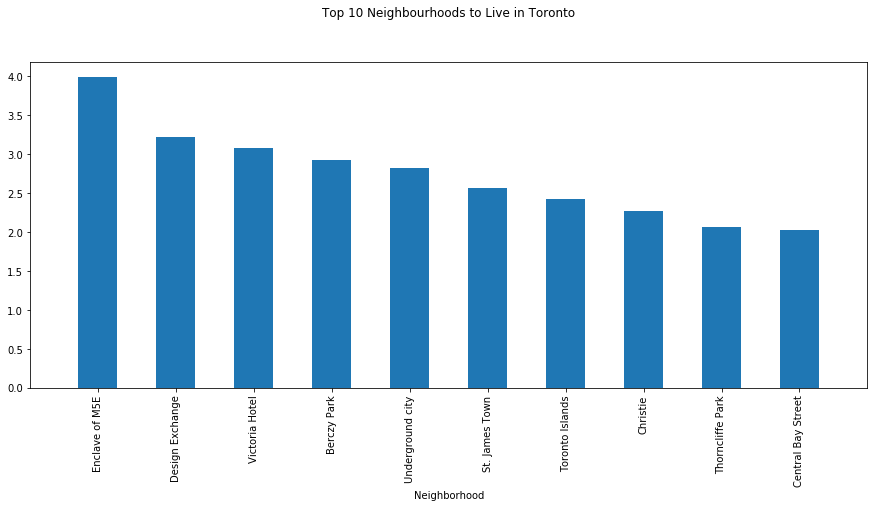

In [1140]:
fdf = normalized_toronto.head(10)

fdf.set_index('Neighborhood', inplace = True)

colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'red' , 'blue' , 'yellow', 'orange']
explode_list = [0.3, 0.2, 0.1, 0.05, 0.05, 0.05 , 0.01 , 0.01 , 0.01 , 0.01 ] # ratio for each continent with which to offset each wedge.

# fdf['Score'].plot(kind='bar',
#                             figsize=(15, 6),
#                             autopct='%1.1f%%', 
#                             startangle=90,    
#                             shadow=True,       
#                             labels=None,         # turn off labels on pie chart
#                             pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
#                             colors=colors_list,  # add custom colors
#                             explode=explode_list # 'explode' lowest 3 continents
#                             )

fdf['Score'].plot(kind='bar', figsize=(15, 6),rot=90)
# scale the title up by 12% to match pctdistance
plt.title('Top 10 Neighbourhoods to Live in Toronto', y=1.12) 

plt.axis('equal') 

# add legend
# plt.legend(labels=fdf.index, loc='upper left') 

plt.show()